# Assignment 4: Application of Neural Networks for Image Processing

In this assignment, you will complete three main tasks to deepen your understanding of neural networks, specifically using Convolutional Neural Networks (CNNs) for image processing:

1. **Image Classification with CNN (30 points)**  
   Create an image classifier using PyTorch, building and training a CNN model to classify images accurately.

2. **Image Denoising with CNN (45 points)**  
   Develop a denoising model using PyTorch, leveraging a CNN to remove noise from images and enhance visual quality.

3. **Kaggle Competition (25 + 20 points)**  
   Participate in a Kaggle competition where you will apply your skills in image classification on a challenging dataset.

---

# Submission Guidelines

### Your submission on A2L should include **five files** in total:

1. **Report** (`report.pdf`): Document your results and answer all assignment-related questions in this PDF.

2. **Code** (`F24-4ML3-Assignment 4.ipynb`): Submit your code in a Jupyter Notebook file, maintaining the original notebook structure provided.

3. **Kaggle Code**: Provide a separate file with the code specifically used for the Kaggle competition.

4. **Kaggle Report** (`kaggle.pdf`): Write a concise report explaining your approach and model used in the competition.

5. **Submission File** (`submission.csv`): Refer to the Kaggle Competition section for details on generating and uploading this file to A2L.


---

**Total Points**: 120 (with an additional 20 bonus points available for Kaggle competition)

**Submission Deadline**: December 2, 2024 11:00PM


In [4]:
# Importing necessary libraries

import torch  # Core PyTorch library for tensor operations
from torchvision import datasets, transforms  # Datasets and transformations for computer vision
import torch.nn as nn  # Neural network components
import torch.optim as optim  # Optimization algorithms
import numpy as np  # Numerical operations
import matplotlib.pyplot as plt  # Plotting
from torch.utils.data import DataLoader, Dataset, random_split, Subset  # Data handling utilities

# SVHN Dataset

In this assignment, you will work with the **Street View House Numbers (SVHN) dataset** to develop a denoising algorithm and a classification task. The SVHN dataset consists of over **600,000** color images of house numbers collected from Google Street View images. Each image is a 32x32 pixel RGB image capturing digits (0-9) in real-world scenarios. The dataset can be found at [this link](http://ufldl.stanford.edu/housenumbers/).

For this assignment, you will use:

- **Training set**: 73,257 images
- **Testing set**: 26,032 images

In [31]:
# Define transformations for the dataset
transform = transforms.ToTensor()

# Load the training and test datasets
trainset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
testset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Set batch size as a parameter
batch_size = 64

# Function to create data loaders with a specified batch size
def get_dataloader(dataset, batch_size, shuffle):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

# Create data loaders for training and testing
trainloader = get_dataloader(trainset, batch_size=batch_size, shuffle=True)
testloader = get_dataloader(testset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


# Visualization of SVHN dataset

In [32]:
# Define the class labels for the SVHN dataset
classes = [str(i) for i in range(10)]

# Function to display a grid of images with specified rows, columns, and class labels
def show_images_grid(dataloader, rows, cols):
    # Get a batch of training images and labels
    dataiter = iter(dataloader)
    images, labels = next(dataiter)

    fig, axes = plt.subplots(rows, cols, figsize=(cols * 2, rows * 2))
    idx = 0
    for i in range(rows):
        for j in range(cols):
            if idx < len(images):
                npimg = images[idx].numpy()
                axes[i, j].imshow(np.transpose(npimg, (1, 2, 0)))
                axes[i, j].set_title(f'Class: {classes[labels[idx]]}')
                axes[i, j].axis('off')
                idx += 1
    plt.tight_layout()
    plt.show()

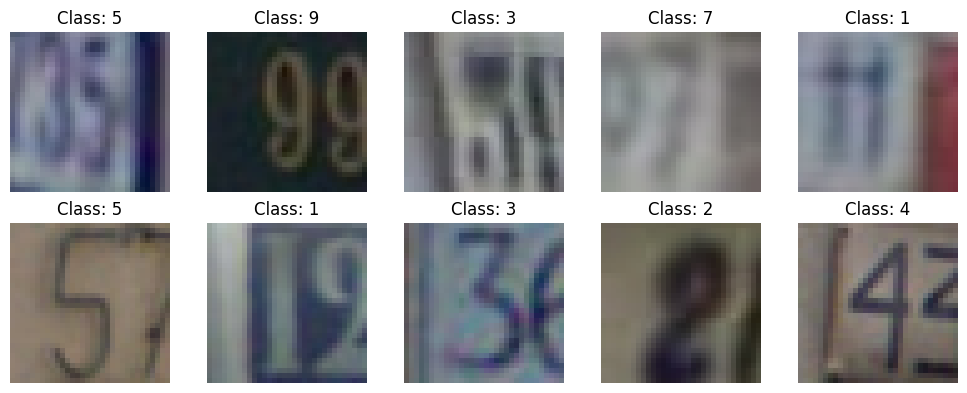

In [33]:
# Display a 2x5 grid of images from trainloader
show_images_grid(trainloader, rows=2, cols=5)

The `del` keyword deletes variables from memory, freeing up space. This is useful in large projects, especially deep learning, where datasets and data loaders use significant memory. Removing these variables ensures available memory for later code and helps avoid conflicts with similar names.


In [34]:
del trainset, testset, trainloader, testloader, transform, batch_size, get_dataloader

# <font color="red">Task 1: SVHN Image Classification Using a Convolutional Neural Network (CNN) (30 points) </font>

In this task, you will complete the implementation of a CNN model and use it to classify images from the SVHN dataset. Your goal is to build an accurate model that can recognize and classify house number digits in real-world images.


When available, a GPU can accelerate neural network training with parallel computations, ideal for large datasets and complex models.


In [35]:
# Set up device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


Hyper-Parameters:

In [36]:
batch_size = 64           # Batch size for data loading
learning_rate = 0.05      # Learning rate for optimizer
num_epochs = 20           # Number of training epochs

Loading the dataset

In [37]:
# Define transformations for SVHN dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4377, 0.4438, 0.4728), (0.1980, 0.2010, 0.1970))
])

# Load training and test datasets with transformations
train_dataset = datasets.SVHN(root='./data', split='train', download=True, transform=transform)
test_dataset = datasets.SVHN(root='./data', split='test', download=True, transform=transform)

# Create data loaders with specified batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


## **A (15 points)** Build the CNN Model


A convolutional layer can be implemented in pytorch like

```
nn.Conv2d(in_channels=, out_channels=, kernel_size=, padding=, stride=).
```

Complete the CNN model implementation with the following architecture:

1. **Convolutional Layers**:
   - Three convolutional layers with:
     - `kernel_size=3`, `stride=1`, `padding=1`
     - Output channels:
       - First layer: 32 channels
       - Second layer: 64 channels
       - Third layer: 128 channels
   - Each convolutional layer is followed by:
     - Batch normalization to stabilize and speed up training
     - ReLU activation for non-linearity
     - Max pooling (`kernel_size=2`, `stride=2`) to reduce spatial dimensions

2. **Fully Connected Layers**:
   - Flatten the output from the convolutional layers.
   - First fully connected layer with 128 units and ReLU activation.
   - Final fully connected layer with 10 units for classification (one for each class in SVHN).

In [38]:
class SVHNClassifier(nn.Module):
    def __init__(self):
        super(SVHNClassifier, self).__init__()
        self.cl1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cl2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.cl3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(128*4*4,128)  #S=Initial Spacial size of 32 was halved 3 times
        self.fc2 = nn.Linear(128,10)


    def forward(self, x):
        x = self.pool1(self.relu(self.bn1(self.cl1(x))))
        x = self.pool2(self.relu(self.bn2(self.cl2(x))))
        x = self.pool3(self.relu(self.bn3(self.cl3(x))))
        x = x.view(x.size(0), -1)
        
        # Fully connected layers
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

## **B (15 points)** Train the network
In the part, we are going to train the SVHN_CNN model to classify SVHN dataset.

1. Finish implementing train and test functions.
2. Include last epoch results for train/test loss and train/test accuracy in your report
3. Plot the train/test losses and train/test accuracies using the plot_metrics function.


In [39]:
# Initialize model and move to device
model = SVHNClassifier().to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # CrossEntropy includes softmax
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

In [40]:
# Define function to evaluate model performance
def evaluate(model, data_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    loss_batches = []

  # Switch to evaluation mode and turn off gradient calculation
  # since parameters are not updated during testing.
    with torch.no_grad():
        for images_batch, labels_batch in data_loader:
            outputs = model(images_batch)
            # The predicted label is the output with the highest activation.
            _, predicted = torch.max(outputs.data, 1)
            total += labels_batch.size(0)
            correct += (predicted == labels_batch).sum().item()

            # Use provided criterion to calculate the loss for the mini batch
            # Append the mini-batch loss to loss_batches array
            batch_loss = criterion(outputs, labels_batch)
            loss_batches.append(batch_loss.item())

    accuracy = 100 * correct / total
    loss = np.mean(loss_batches)

    model.train()

    return accuracy, loss

In [41]:
# Training the model
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(num_epochs):
    for i, (images_batch, labels_batch) in enumerate(train_loader):
        optimizer.zero_grad() # Clear the gradients
        outputs = model(images_batch) # Forward pass
        loss = criterion(outputs, labels_batch) # Calculate loss
        loss.backward() # Backward pass
        optimizer.step() # Update weights
        
    train_accuracy, train_loss = evaluate(model, train_loader, criterion)
    test_accuracy, test_loss = evaluate(model, test_loader, criterion)


    print(f'Epoch {epoch+1:02d}/{num_epochs:02d} - Train Loss: {train_loss:.6f}, Train Acc: {train_accuracy:.2f}%')
    print(f'            - Test Loss: {test_loss:.6f}, Test Acc: {test_accuracy:.2f}%')
    print("-" * 60)

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

Epoch 01/20 - Train Loss: 0.404835, Train Acc: 87.66%
            - Test Loss: 0.459343, Test Acc: 86.01%
------------------------------------------------------------
Epoch 02/20 - Train Loss: 0.351508, Train Acc: 89.04%
            - Test Loss: 0.427294, Test Acc: 87.29%
------------------------------------------------------------
Epoch 03/20 - Train Loss: 0.248909, Train Acc: 92.59%
            - Test Loss: 0.336801, Test Acc: 90.18%
------------------------------------------------------------
Epoch 04/20 - Train Loss: 0.238865, Train Acc: 92.54%
            - Test Loss: 0.342912, Test Acc: 89.91%
------------------------------------------------------------
Epoch 05/20 - Train Loss: 0.187135, Train Acc: 94.77%
            - Test Loss: 0.301169, Test Acc: 91.45%
------------------------------------------------------------
Epoch 06/20 - Train Loss: 0.196810, Train Acc: 94.12%
            - Test Loss: 0.349591, Test Acc: 89.91%
-----------------------------------------------------------

In [17]:
def plot_metrics(train_metrics, test_metrics, metric_name):
    plt.figure(figsize=(8, 6))
    epochs = np.arange(len(train_metrics))

    plt.plot(epochs, train_metrics, label=f'Train {metric_name}', color='blue')
    plt.plot(epochs, test_metrics, label=f'Test {metric_name}', color='red')

    plt.xlabel('Epochs')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} over Epochs')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

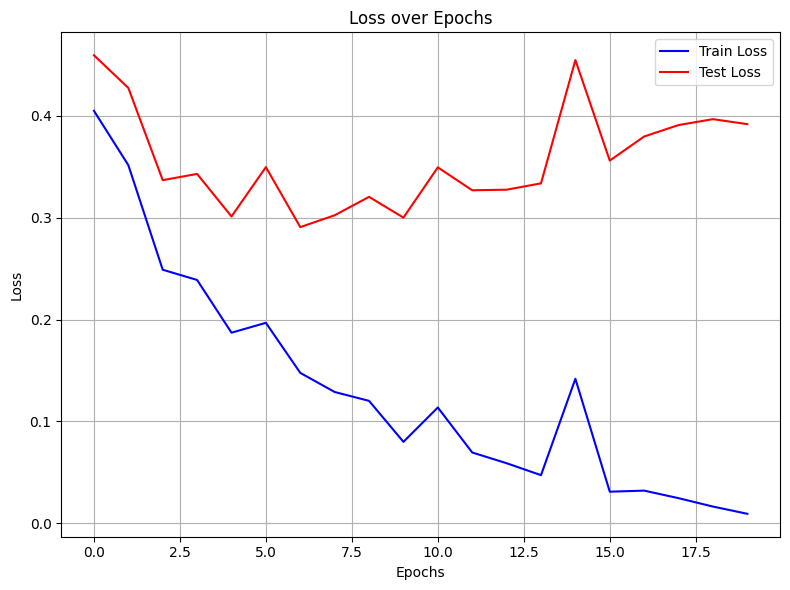

In [43]:
# Plot loss
plot_metrics(train_losses, test_losses, 'Loss')

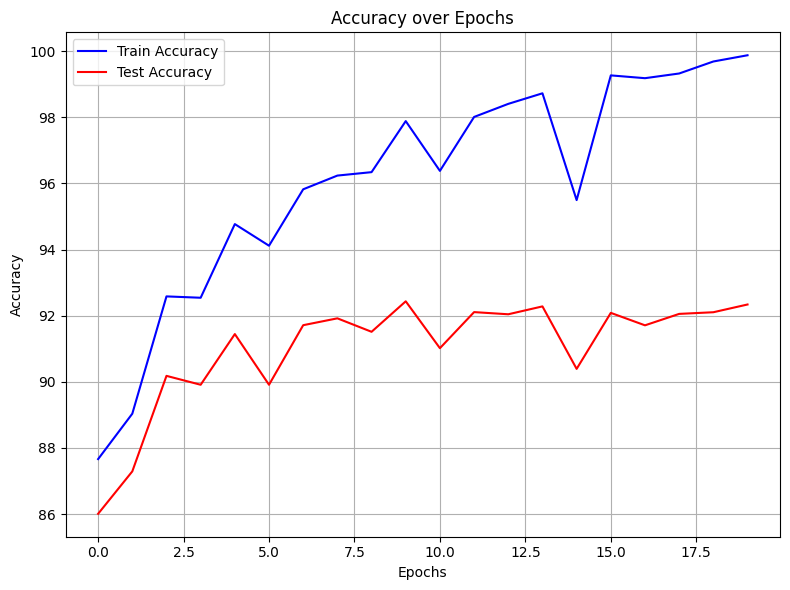

In [44]:
# Plot accuracy
plot_metrics(train_accuracies, test_accuracies, 'Accuracy')

# <font color="red">Task 2: SVHN Denoising with Convolution Neural Network (CNN) (45 points) </font>
Convolutional Neural Network (CNN) have also been quite successful in the field of image processing. In this part, you are asked to finish the implementation of the CNN model and use the model to denoise images from SVHN.

The objective of tasks in the assignment is to train a network that, given a noisy image, recovers the original image. Therefore, each training point consists of the input (noisy image) and the expected output (true image).






Again, we remove these variables ensures available memory for later code and helps avoid conflicts with similar names.

In [56]:
del device, batch_size, learning_rate, num_epochs,\
     train_dataset, test_dataset, train_loader, test_loader, transform,\
     SVHNClassifier, model, criterion, optimizer, evaluate,\
     train_losses, test_losses, train_accuracies, test_accuracies, show_images_grid, classes

NameError: name 'batch_size' is not defined

In [5]:
# Set up device for training (use GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


## Create the Noisy dataset

### Step 1: Defining a Custom Noise Transformation
First, we define a custom transformation that applies noise to each image by randomly dropping pixels. This transformation will be used to generate a noisy version of every image in the dataset.

In [6]:
# Custom transformation to add noise by dropping pixels with a given probability for each channel independently
class AddNoiseTransform:
    def __init__(self, drop_prob=0.1):
        self.drop_prob = drop_prob

    def __call__(self, img):
        channel_mask = (torch.rand(img.shape) > self.drop_prob).float()
        noisy_img = img * channel_mask
        return noisy_img

### Step 2: Creating a Dataset of Paired Images: Original and Noisy
We define a dataset that pairs each original image with a corresponding noisy image. This dataset is structured so that each data sample includes both the clean image (as the label) and the noisified version (as the feature). We then create PyTorch dataloaders where each element contains a pair of original and noisy images.

In [7]:
# PairDataset class that returns a pair of images: (original, noisy)
class PairDataset(Dataset):
    def __init__(self, dataset_origin, dataset_noisy):
        assert len(dataset_origin) == len(dataset_noisy), "Datasets must be of the same length"
        self.dataset_origin = dataset_origin
        self.dataset_noisy = dataset_noisy

    def __getitem__(self, index):
        clean_img, _ = self.dataset_origin[index]
        noisy_img, _ = self.dataset_noisy[index]
        return clean_img, noisy_img

    def __len__(self):
        return len(self.dataset_origin)

In [8]:
# Function to create paired dataset for specific classes
def create_paired_dataloader(classes, num_samples=1500, batch_size=64, drop_prob=0.5, split='train'):
    """
    Creates a DataLoader for a paired dataset with noisy and clean images from specified classes.

    Parameters:
    - classes (list): List of class labels to include (e.g., [0, 1, 2, 3, 4] or [5, 6, 7, 8, 9]).
    - num_samples (int): Number of samples to use from the filtered classes.
    - batch_size (int): Batch size for the DataLoader.
    - drop_prob (float): Drop probability for AddNoiseTransform.
    - split (str): Dataset split to load ('train' or 'test').

    Returns:
    - DataLoader: A DataLoader for the paired dataset.
    """

    # Define transformations
    transform_clean = transforms.ToTensor()
    transform_noisy = transforms.Compose([
        transforms.ToTensor(),
        AddNoiseTransform(drop_prob=drop_prob)
    ])

    # Load the specified dataset split
    dataset_clean_full = datasets.SVHN(root='./data', split=split, download=True, transform=transform_clean)
    dataset_noisy_full = datasets.SVHN(root='./data', split=split, download=True, transform=transform_noisy)

    # Filter to include only samples with specified classes
    indices = [i for i, (_, label) in enumerate(dataset_clean_full) if label in classes]

    # Take only the first `num_samples` samples after filtering
    subset_indices = indices[:num_samples]

    # Create clean and noisy subsets
    dataset_clean = Subset(dataset_clean_full, subset_indices)
    dataset_noisy = Subset(dataset_noisy_full, subset_indices)

    # Create the paired dataset
    paired_dataset = PairDataset(dataset_clean, dataset_noisy)

    # DataLoader for paired dataset
    paired_dataloader = DataLoader(paired_dataset, batch_size=batch_size, shuffle=True)

    return paired_dataloader

## **Task A (10 points): Implementing a CNN for Image Denoising**

In this task, you will implement a Convolutional Neural Network (CNN) to map noisy images to their original, clean versions. This architecture consists of two convolutional layers.

### **Architecture Details**

1. **First Convolutional Layer**
   - **Setup**: `kernel_size=3`, `padding=1`, `stride=1` to maintain image dimensions.
   - **Input**: 32x32x3 images.
   - **Output**: Feature maps of size 32x32x30.
   - **Activation**: Apply ReLU for non-linearity.

2. **Second Convolutional Layer**
   - **Setup**: Same kernel size, padding, and stride as above.
   - **Output**: 32x32x3 to match the original image dimensions.
   - **Activation**: Sigmoid to constrain values between 0 and 1.

3. **Hyperparameters**
   - `input_channels=3`, `output_channels=3`, `feature_maps=30`.

### **Implementation Requirements**

Using these guidelines, implement the CNN model in PyTorch with `torch.nn.Conv2d` for the layers, and `torch.nn.ReLU` and `torch.nn.Sigmoid` for activations.

In [9]:
class ImageDenoisingCNN(nn.Module):
    def __init__(self):
        super(ImageDenoisingCNN, self).__init__()
        self.cl1 = nn.Conv2d(in_channels=3, out_channels=30, kernel_size=3, padding=1, stride=1)
        self.cl2 = nn.Conv2d(in_channels=30, out_channels=3, kernel_size=3, padding=1, stride=1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()


    def forward(self, x):
        x = self.relu(self.cl1(x))
        x = self.sigmoid(self.cl2(x))
        return x

To understand the model’s complexity, we can calculate the total number of trainable parameters in ImageDenoisingCNN. Each parameter contributes to the model's ability to learn patterns in the data.

In [10]:
model = ImageDenoisingCNN()

# Calculate and print the number of trainable parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print('Total number of trainable parameters in ImageDenoisingCNN:', num_params)

Total number of trainable parameters in ImageDenoisingCNN: 1653


## **Task B (20 points)**: Denoising SVHN Images
This task involves building and evaluating a model that can remove noise from SVHN images in the first 5 classes (0 through 4). The model is trained and tested on a dataset of noisy images paired with their clean counterparts, using only 1,500 samples per class.

**Objectives**:
1. Complete the training function: This function should return the average training and test losses for each epoch.
2. Complete the testing function: This function should compute the average test loss across all batches.
3. Denoise SVHN Images: Train the model to denoise images from the first 5 classes.

Include the last epoch train/test values and last epoch sample images in your report.

In [11]:
# Display a single row of images with specified columns
def show_images_grid2(images, title, cols):
    fig, axes = plt.subplots(1, cols, figsize=(cols * 2, 2))
    if cols == 1:
        axes = [axes]

    for idx in range(cols):
        if idx < len(images):
            img = images[idx].numpy().transpose((1, 2, 0))
            axes[idx].imshow(img)
            axes[idx].set_title(title)
            axes[idx].axis('off')

    plt.tight_layout()
    plt.show()

In [12]:
def train(train_loader, test_loader, model, epochs, loss_function, optimizer, device='cuda'):
    """
    Train the model on the training dataset and evaluate it on the test dataset.

    Parameters:
    - train_loader: DataLoader for the training set
    - test_loader: DataLoader for the test set
    - model: Neural network model to train
    - epochs: Number of training epochs
    - loss_function: Loss function for training
    - optimizer: Optimizer for updating model weights
    - device: Device to use for training ('cuda' or 'cpu')

    Returns:
    - train_loss_epochs: List of average training losses per epoch
    - test_loss_epochs: List of average test losses per epoch
    """

    # Move model to the specified device

    model = model.to(device)

    train_loss_epochs = []
    test_loss_epochs = []

    # Loop over the dataset for a specified number of epochs
    for epoch in range(epochs):
        model.train()  # Set model to training mode
        train_loss_batches = []

        # Loop over batches in the training data

        for batch_idx, (clean_images, noisy_images) in enumerate(train_loader):
            optimizer.zero_grad() # Clear the gradients
            denoised_images = model(noisy_images) # Forward pass
            loss = loss_function(denoised_images, clean_images) # Calculate loss
            loss.backward() # Backward pass
            optimizer.step() # Update weights

            # Display sample results every 5 epochs, at the last batch of each epoch
            if epoch % 5 == 0 and batch_idx == len(train_loader) - 1:
                show_images_grid2(clean_images[:5].detach().cpu(), title= "Clean", cols=5)
                show_images_grid2(noisy_images[:5].detach().cpu(), title= "Noisy", cols=5)
                show_images_grid2(denoised_images[:5].detach().cpu(), title= "Denoised", cols=5)

        train_loss_epoch = evaluate(train_loader, model, loss_function, device)
        train_loss_epochs.append(train_loss_epoch)


        # Calculate average training loss for the epoch

        average_train_loss = sum(train_loss_epochs)/len(train_loss_epochs)
        train_loss_batches.append(average_train_loss)

        # Evaluate model on the test set and calculate test loss
        test_loss_epoch = evaluate(test_loader, model, loss_function, device)
        test_loss_epochs.append(test_loss_epoch)

        # Print losses for the current epoch
        print(f'Epoch {epoch+1:02d}/{epochs:02d} - Train Loss: {train_loss_epoch:.6f}, Test Loss: {test_loss_epoch:.6f}')

    return train_loss_epochs, test_loss_epochs

In [ ]:
def evaluate(dataloader, model, loss_function, device='cuda'):
    """
    Evaluate the model on the test dataset and return the average loss.
    """
    model.eval()
    model = model.to(device)
    test_losses = []

    with torch.no_grad():  # Disable gradient calculation for testing
        for clean_images, noise_images in dataloader:
          denoised_images = model(noisy_images)
          # The predicted label is the output with the highest activation.
          batch_loss = loss_function(denoised_images, clean_images)  # Compare denoised to clean
          test_losses.append(batch_loss.item())

    model.train()  # Set the model back to training mode

    return np.mean(test_losses)  # Return average loss over the dataset

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat


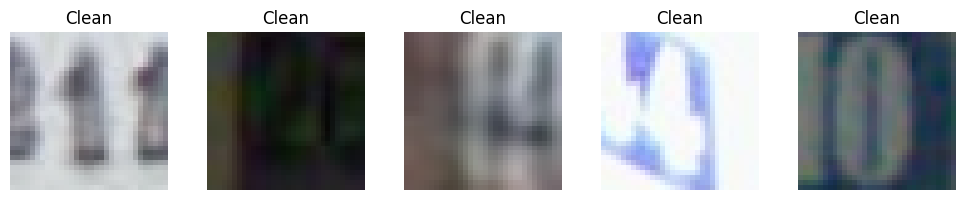

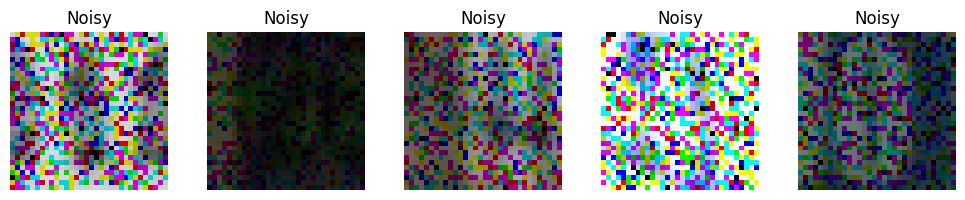

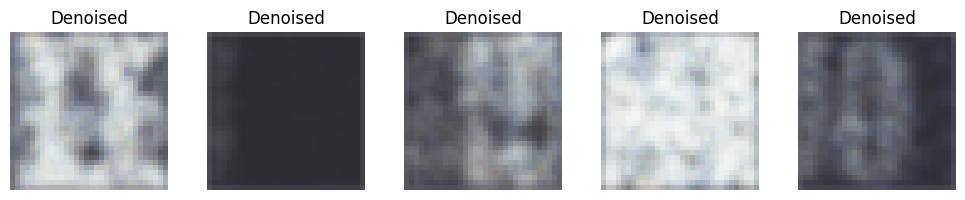

Epoch 01/100 - Train Loss: 0.152593, Test Loss: 0.151891
Epoch 02/100 - Train Loss: 0.152990, Test Loss: 0.151382
Epoch 03/100 - Train Loss: 0.153121, Test Loss: 0.152225
Epoch 04/100 - Train Loss: 0.152895, Test Loss: 0.151537
Epoch 05/100 - Train Loss: 0.152822, Test Loss: 0.151915


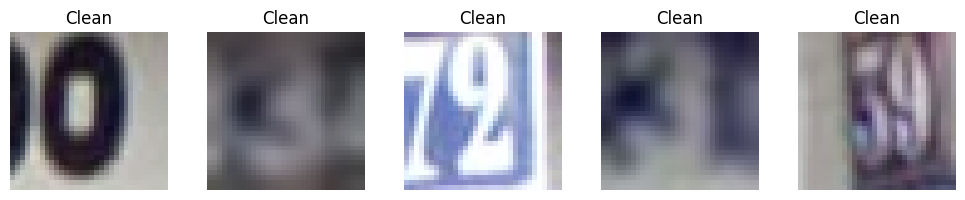

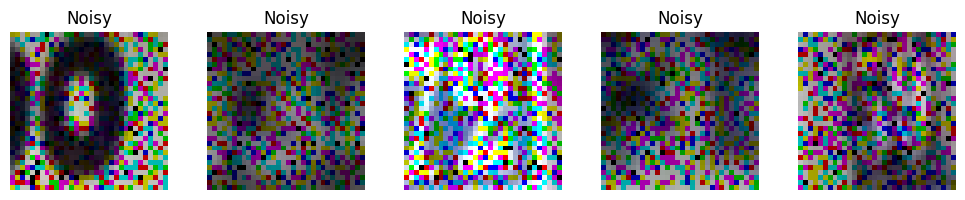

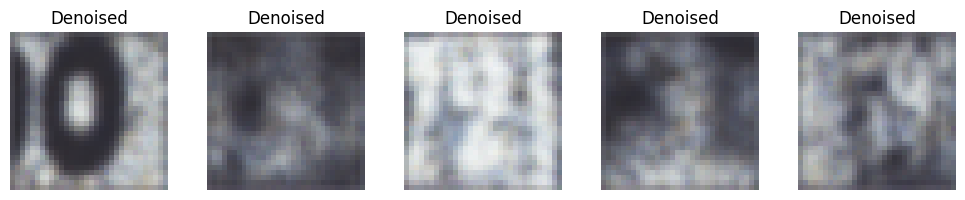

Epoch 06/100 - Train Loss: 0.152903, Test Loss: 0.151535
Epoch 07/100 - Train Loss: 0.151915, Test Loss: 0.151003
Epoch 08/100 - Train Loss: 0.153130, Test Loss: 0.150892
Epoch 09/100 - Train Loss: 0.152285, Test Loss: 0.150979
Epoch 10/100 - Train Loss: 0.151260, Test Loss: 0.151060


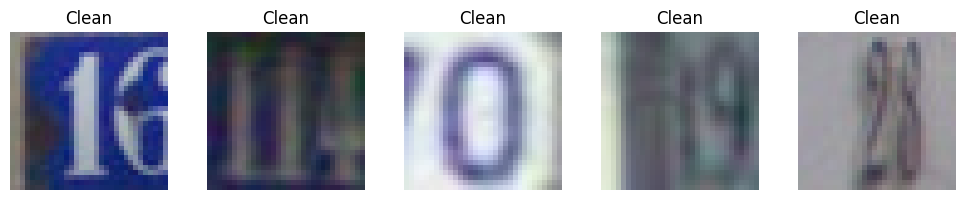

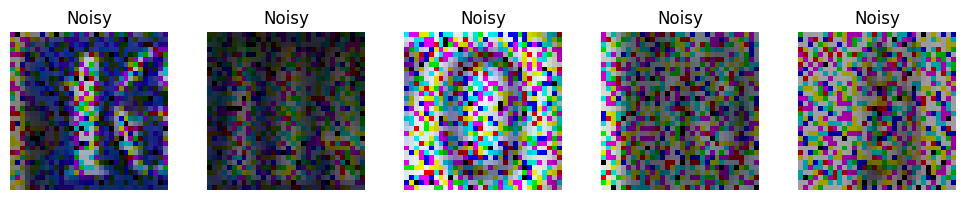

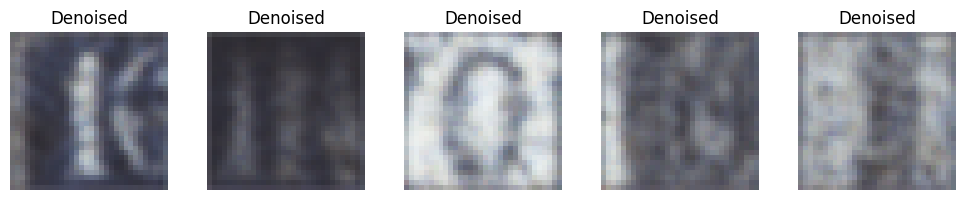

Epoch 11/100 - Train Loss: 0.152973, Test Loss: 0.152049
Epoch 12/100 - Train Loss: 0.152265, Test Loss: 0.151687
Epoch 13/100 - Train Loss: 0.152281, Test Loss: 0.151537
Epoch 14/100 - Train Loss: 0.151713, Test Loss: 0.151291
Epoch 15/100 - Train Loss: 0.152570, Test Loss: 0.151808


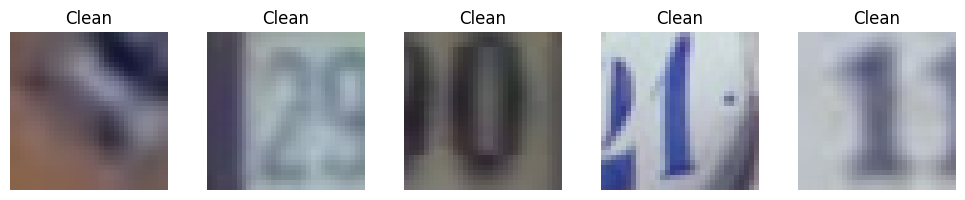

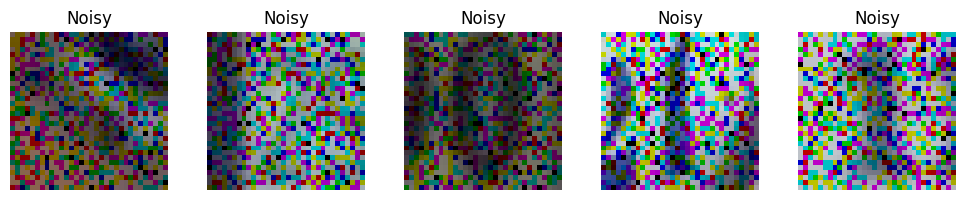

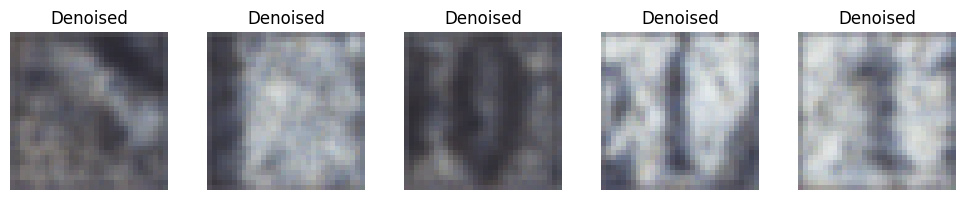

Epoch 16/100 - Train Loss: 0.152420, Test Loss: 0.151100
Epoch 17/100 - Train Loss: 0.152197, Test Loss: 0.151371
Epoch 18/100 - Train Loss: 0.152068, Test Loss: 0.151424
Epoch 19/100 - Train Loss: 0.152401, Test Loss: 0.151315
Epoch 20/100 - Train Loss: 0.152293, Test Loss: 0.151685


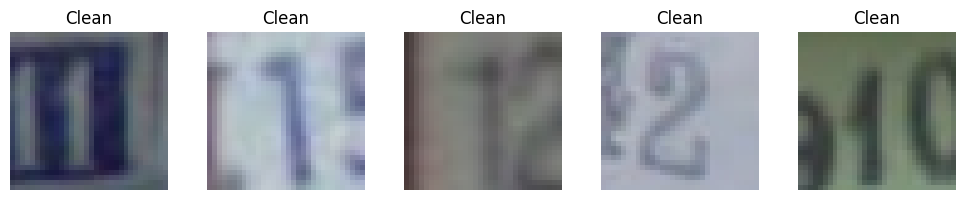

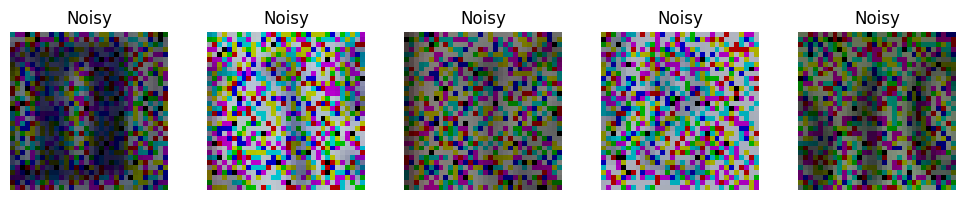

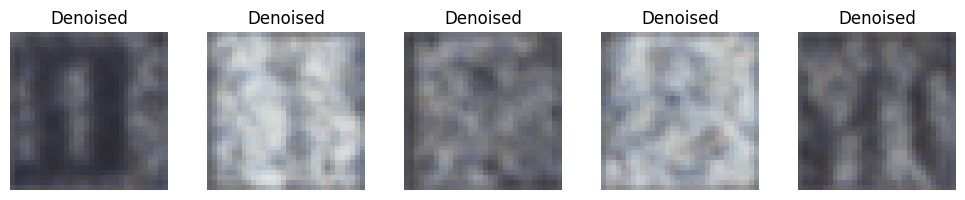

Epoch 21/100 - Train Loss: 0.152070, Test Loss: 0.150930
Epoch 22/100 - Train Loss: 0.151506, Test Loss: 0.151831
Epoch 23/100 - Train Loss: 0.151553, Test Loss: 0.151254
Epoch 24/100 - Train Loss: 0.152034, Test Loss: 0.151591
Epoch 25/100 - Train Loss: 0.152024, Test Loss: 0.150474


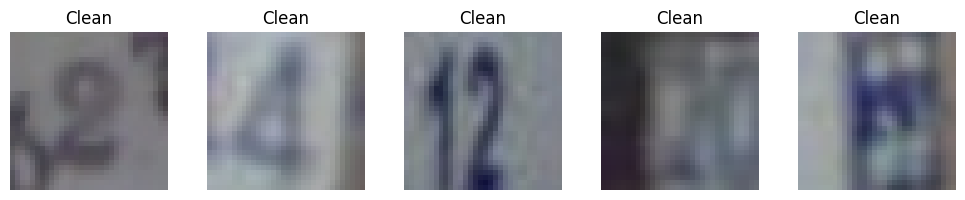

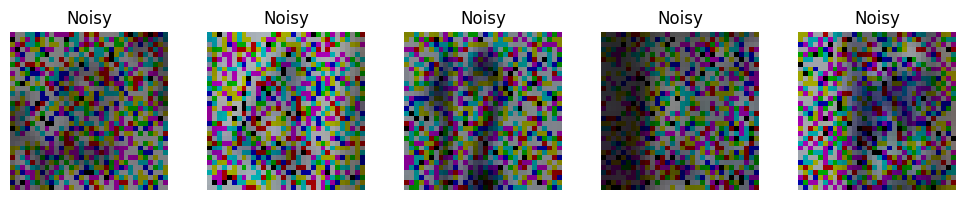

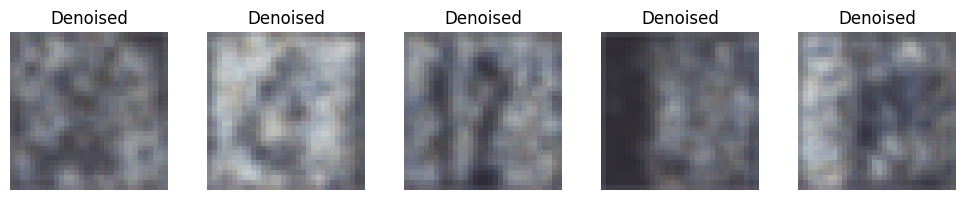

Epoch 26/100 - Train Loss: 0.152058, Test Loss: 0.150313
Epoch 27/100 - Train Loss: 0.152492, Test Loss: 0.151076
Epoch 28/100 - Train Loss: 0.151697, Test Loss: 0.150878
Epoch 29/100 - Train Loss: 0.152320, Test Loss: 0.151213
Epoch 30/100 - Train Loss: 0.151550, Test Loss: 0.150769


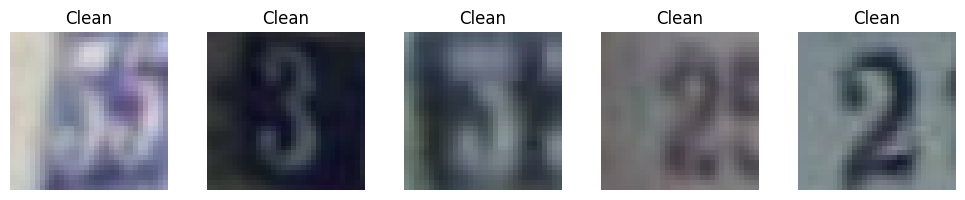

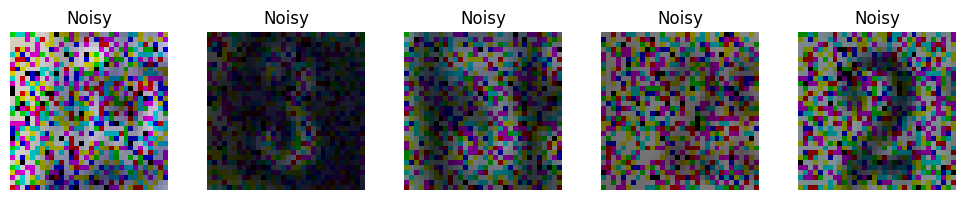

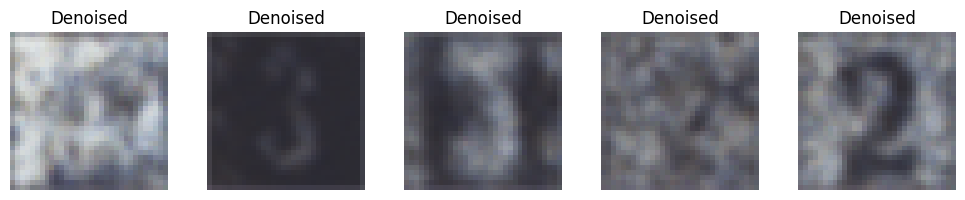

Epoch 31/100 - Train Loss: 0.151434, Test Loss: 0.150543
Epoch 32/100 - Train Loss: 0.151899, Test Loss: 0.151201
Epoch 33/100 - Train Loss: 0.151742, Test Loss: 0.150840
Epoch 34/100 - Train Loss: 0.151360, Test Loss: 0.150383
Epoch 35/100 - Train Loss: 0.151202, Test Loss: 0.150650


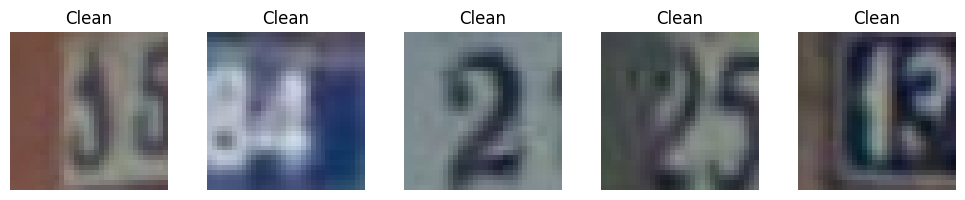

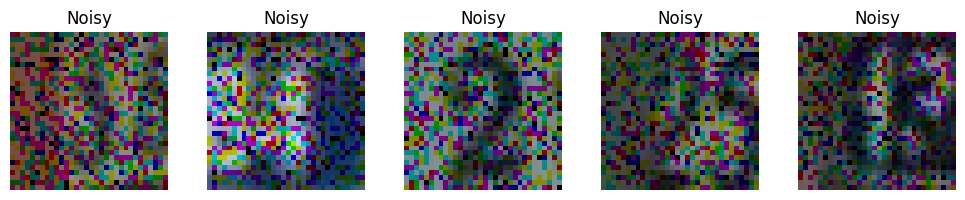

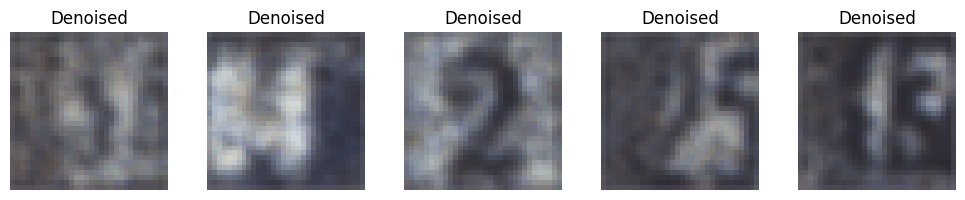

Epoch 36/100 - Train Loss: 0.151520, Test Loss: 0.150226
Epoch 37/100 - Train Loss: 0.151029, Test Loss: 0.151135
Epoch 38/100 - Train Loss: 0.150878, Test Loss: 0.151139
Epoch 39/100 - Train Loss: 0.151067, Test Loss: 0.150382
Epoch 40/100 - Train Loss: 0.151583, Test Loss: 0.150681


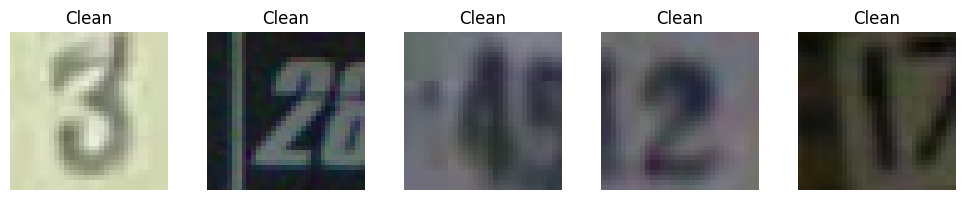

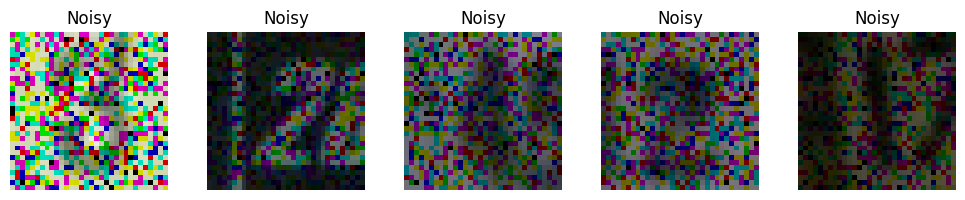

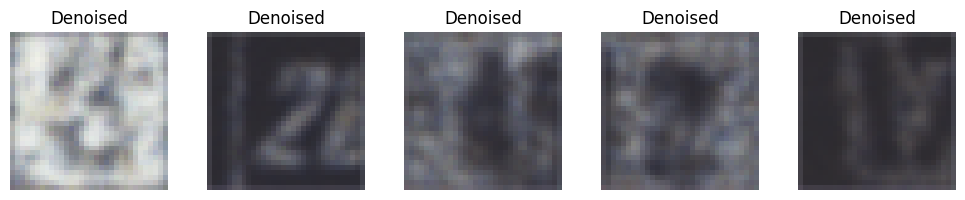

Epoch 41/100 - Train Loss: 0.151444, Test Loss: 0.150924
Epoch 42/100 - Train Loss: 0.150924, Test Loss: 0.149969
Epoch 43/100 - Train Loss: 0.151268, Test Loss: 0.150355
Epoch 44/100 - Train Loss: 0.151346, Test Loss: 0.150076
Epoch 45/100 - Train Loss: 0.151202, Test Loss: 0.150243


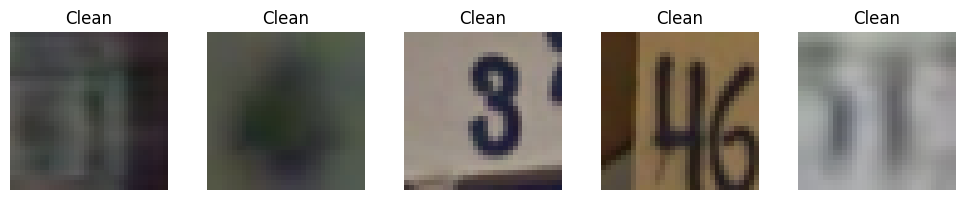

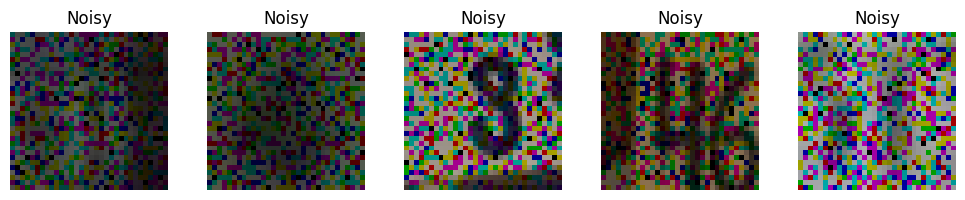

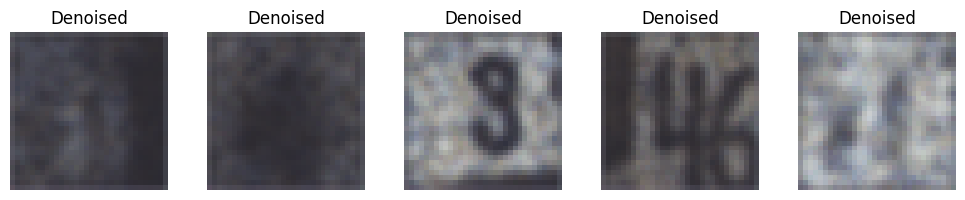

Epoch 46/100 - Train Loss: 0.151396, Test Loss: 0.150024
Epoch 47/100 - Train Loss: 0.151133, Test Loss: 0.149541
Epoch 48/100 - Train Loss: 0.150461, Test Loss: 0.150213
Epoch 49/100 - Train Loss: 0.151058, Test Loss: 0.150863
Epoch 50/100 - Train Loss: 0.150951, Test Loss: 0.149854


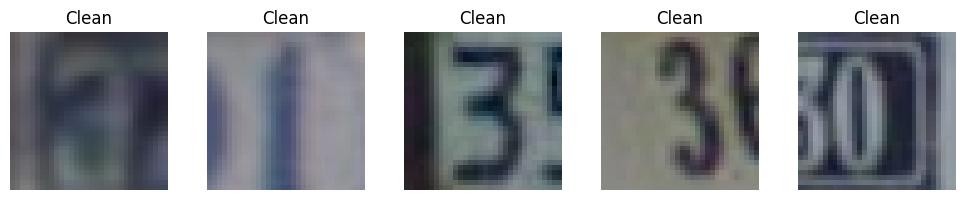

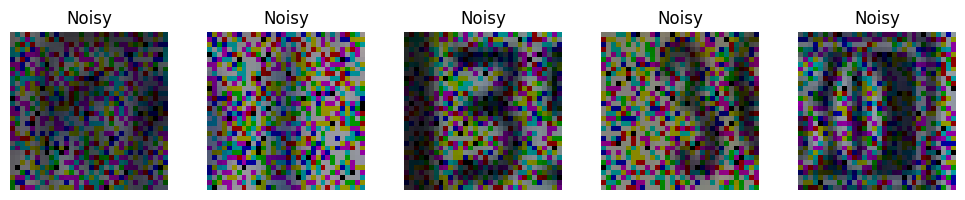

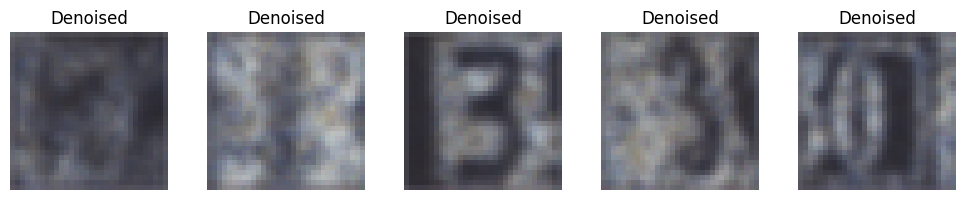

Epoch 51/100 - Train Loss: 0.151281, Test Loss: 0.150897
Epoch 52/100 - Train Loss: 0.150515, Test Loss: 0.149477
Epoch 53/100 - Train Loss: 0.150849, Test Loss: 0.149567
Epoch 54/100 - Train Loss: 0.151604, Test Loss: 0.149191
Epoch 55/100 - Train Loss: 0.150625, Test Loss: 0.149433


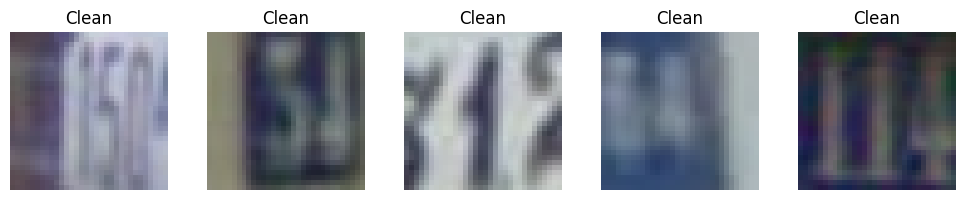

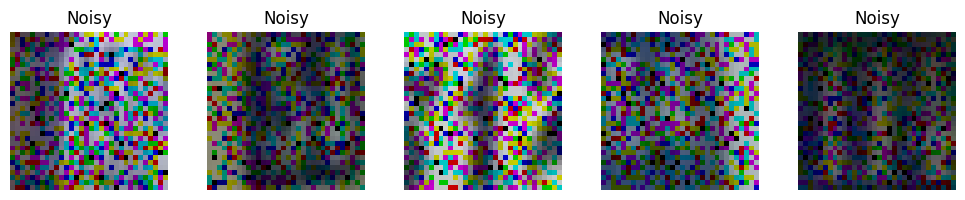

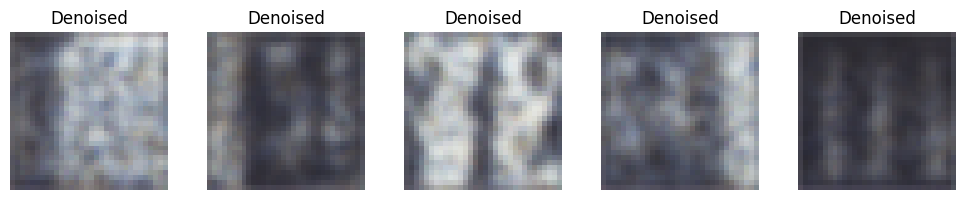

Epoch 56/100 - Train Loss: 0.150756, Test Loss: 0.149656
Epoch 57/100 - Train Loss: 0.150436, Test Loss: 0.149217
Epoch 58/100 - Train Loss: 0.149986, Test Loss: 0.149258
Epoch 59/100 - Train Loss: 0.150029, Test Loss: 0.149884
Epoch 60/100 - Train Loss: 0.150952, Test Loss: 0.149784


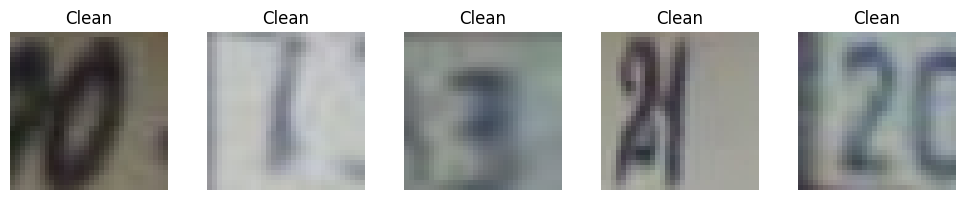

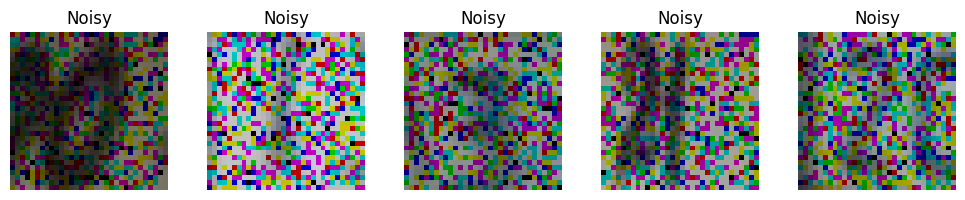

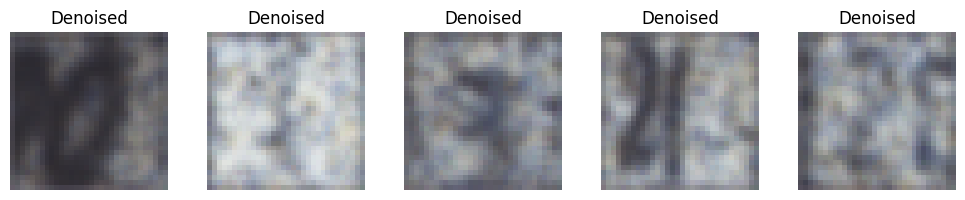

Epoch 61/100 - Train Loss: 0.150620, Test Loss: 0.148944
Epoch 62/100 - Train Loss: 0.150356, Test Loss: 0.148889
Epoch 63/100 - Train Loss: 0.149892, Test Loss: 0.149755
Epoch 64/100 - Train Loss: 0.149985, Test Loss: 0.149080
Epoch 65/100 - Train Loss: 0.150570, Test Loss: 0.149794


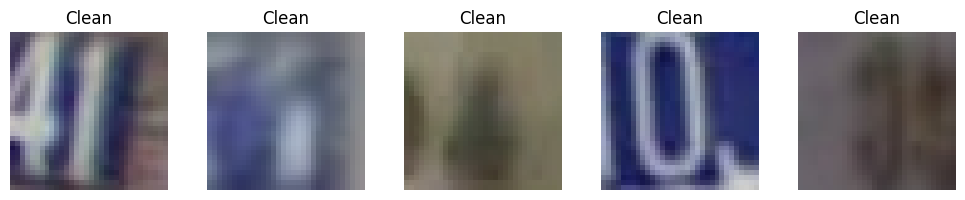

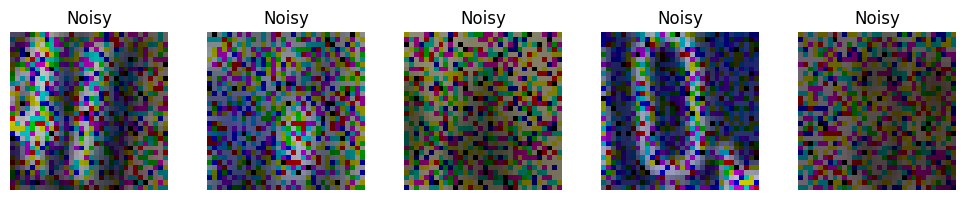

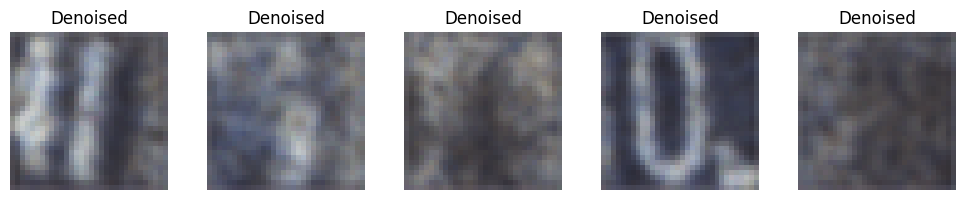

Epoch 66/100 - Train Loss: 0.149822, Test Loss: 0.149654
Epoch 67/100 - Train Loss: 0.150528, Test Loss: 0.149676
Epoch 68/100 - Train Loss: 0.150581, Test Loss: 0.149136
Epoch 69/100 - Train Loss: 0.150151, Test Loss: 0.149081
Epoch 70/100 - Train Loss: 0.150103, Test Loss: 0.149290


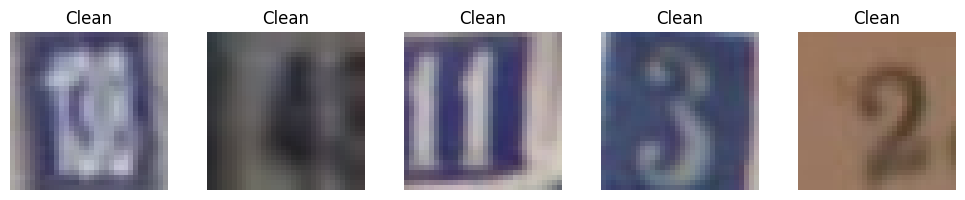

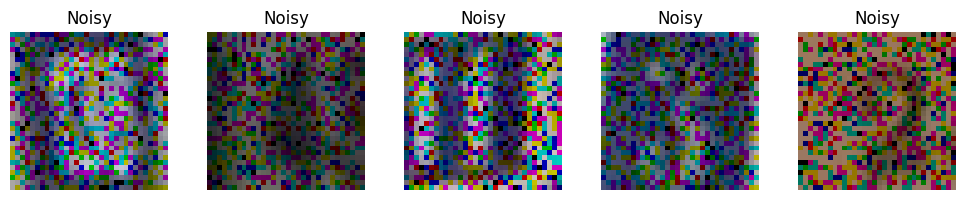

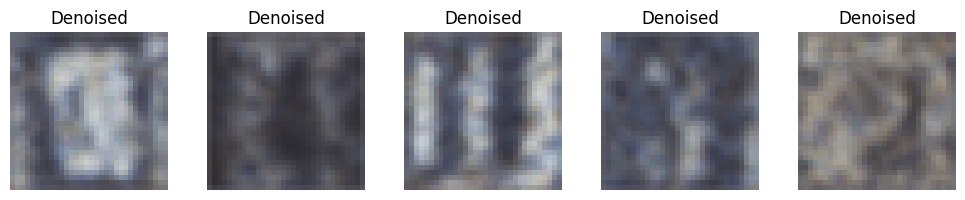

Epoch 71/100 - Train Loss: 0.149550, Test Loss: 0.148190
Epoch 72/100 - Train Loss: 0.149952, Test Loss: 0.148762
Epoch 73/100 - Train Loss: 0.149776, Test Loss: 0.149073
Epoch 74/100 - Train Loss: 0.149388, Test Loss: 0.149354
Epoch 75/100 - Train Loss: 0.150191, Test Loss: 0.149466


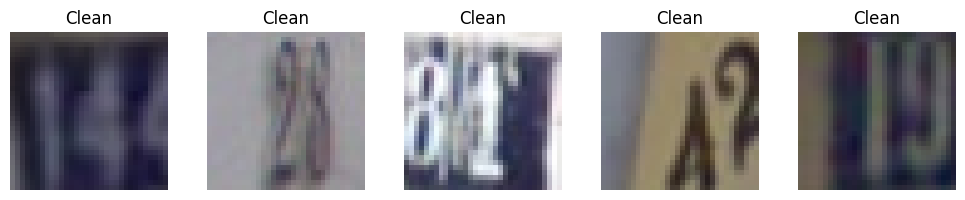

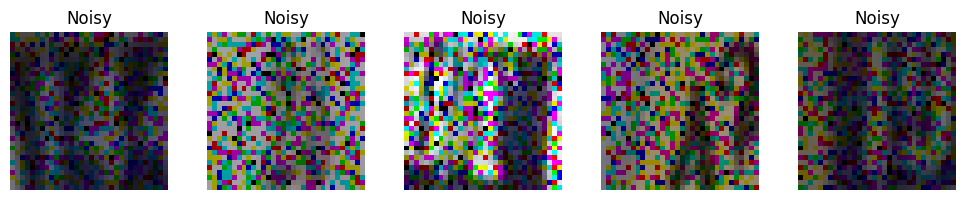

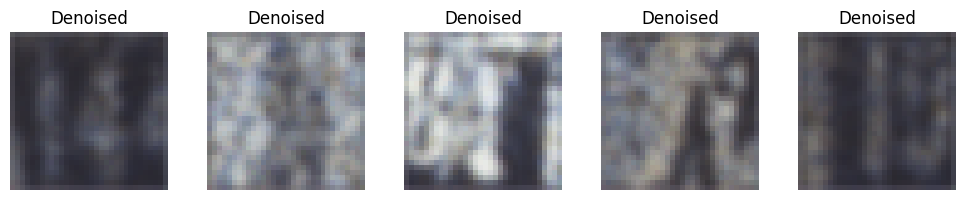

Epoch 76/100 - Train Loss: 0.148869, Test Loss: 0.148245
Epoch 77/100 - Train Loss: 0.149454, Test Loss: 0.149281
Epoch 78/100 - Train Loss: 0.149522, Test Loss: 0.149283
Epoch 79/100 - Train Loss: 0.148951, Test Loss: 0.148827
Epoch 80/100 - Train Loss: 0.149594, Test Loss: 0.148818


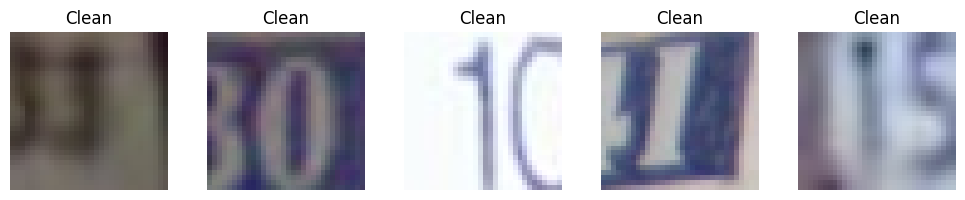

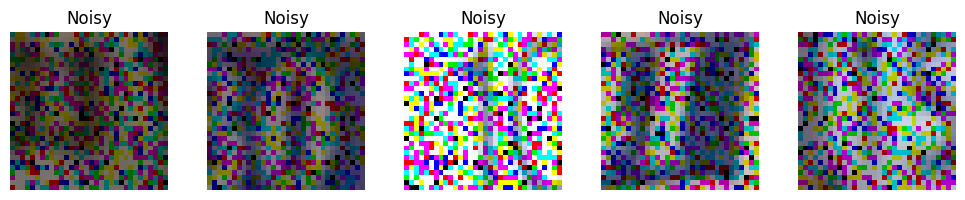

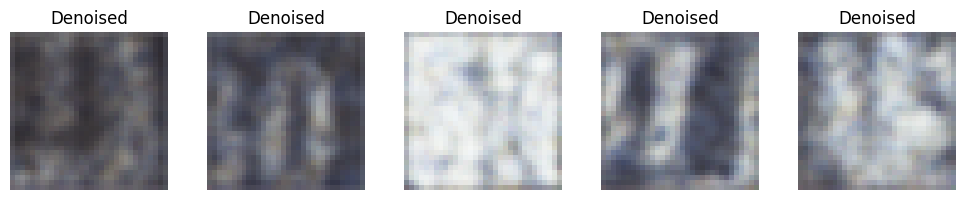

Epoch 81/100 - Train Loss: 0.149393, Test Loss: 0.148668
Epoch 82/100 - Train Loss: 0.148986, Test Loss: 0.148533
Epoch 83/100 - Train Loss: 0.149567, Test Loss: 0.148556
Epoch 84/100 - Train Loss: 0.148791, Test Loss: 0.149152
Epoch 85/100 - Train Loss: 0.149500, Test Loss: 0.148409


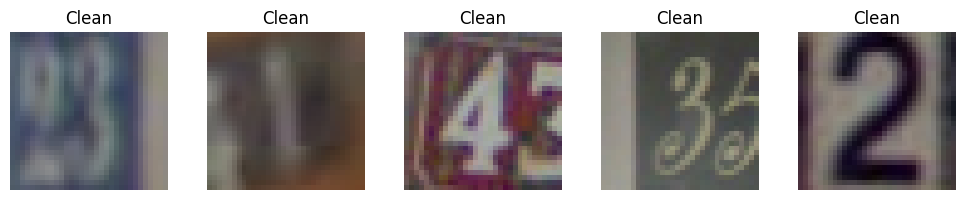

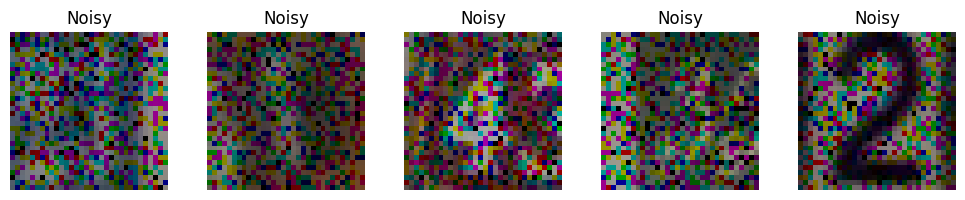

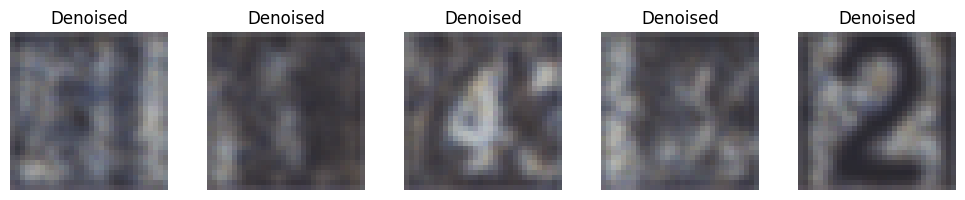

Epoch 86/100 - Train Loss: 0.149513, Test Loss: 0.148514
Epoch 87/100 - Train Loss: 0.148848, Test Loss: 0.148416
Epoch 88/100 - Train Loss: 0.149329, Test Loss: 0.148365
Epoch 89/100 - Train Loss: 0.149694, Test Loss: 0.148230
Epoch 90/100 - Train Loss: 0.149387, Test Loss: 0.147952


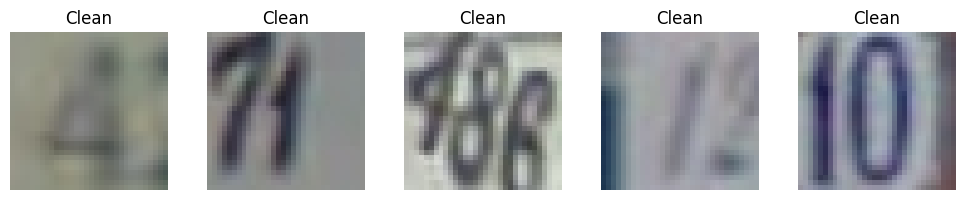

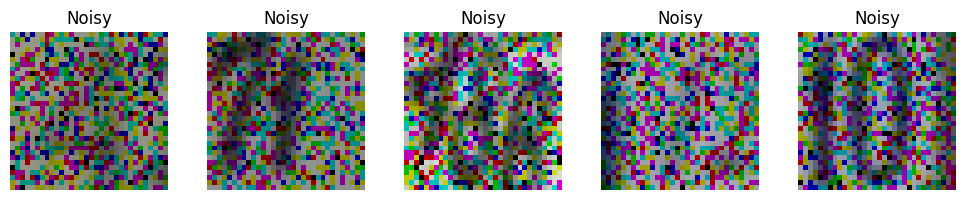

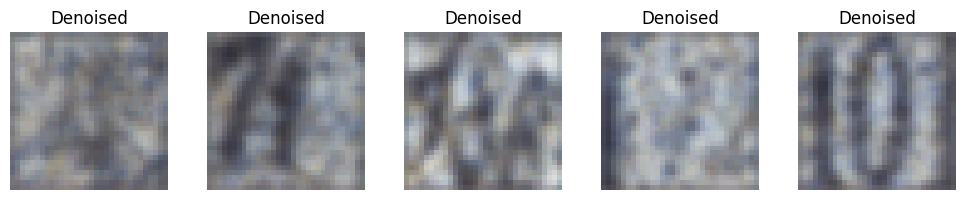

Epoch 91/100 - Train Loss: 0.149188, Test Loss: 0.148110
Epoch 92/100 - Train Loss: 0.148644, Test Loss: 0.147877
Epoch 93/100 - Train Loss: 0.148581, Test Loss: 0.148319
Epoch 94/100 - Train Loss: 0.148294, Test Loss: 0.148378
Epoch 95/100 - Train Loss: 0.148679, Test Loss: 0.147896


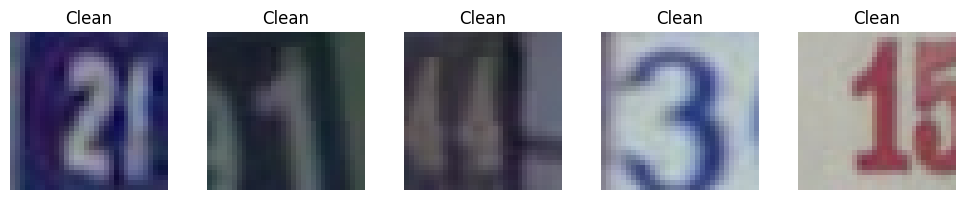

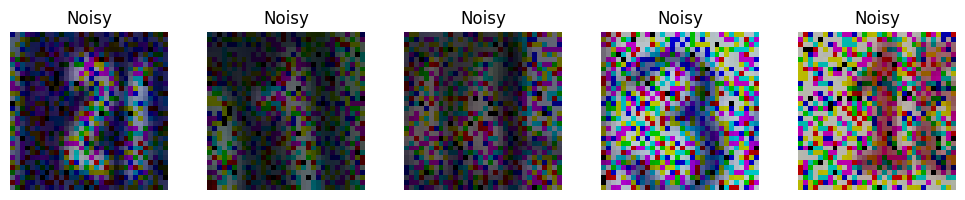

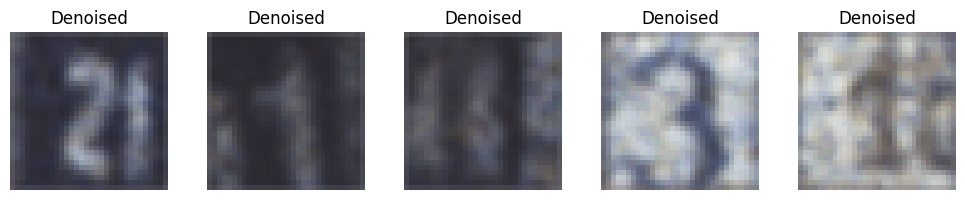

Epoch 96/100 - Train Loss: 0.148613, Test Loss: 0.148191
Epoch 97/100 - Train Loss: 0.148763, Test Loss: 0.148490
Epoch 98/100 - Train Loss: 0.148854, Test Loss: 0.147777
Epoch 99/100 - Train Loss: 0.148978, Test Loss: 0.147595
Epoch 100/100 - Train Loss: 0.148592, Test Loss: 0.147739


In [15]:
learning_rate = 0.05
batch_size = 64
drop_rate = 0.3
num_samples = 1500
num_epochs = 100


criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load data
paired_trainloader_first_five = create_paired_dataloader(list(range(5)), num_samples, batch_size, drop_rate, 'train')
paired_testloader_first_five = create_paired_dataloader(list(range(5)), num_samples, batch_size, drop_rate, 'test')


# Train the model
train_loss_epochs, test_loss_epochs = train(paired_trainloader_first_five, paired_testloader_first_five,\
                                            model, num_epochs, criterion, optimizer, device)

## **Task C (5 points): Plotting Training and Testing Losses Over Epochs**

To visualize the learning process of your model, plot the training and testing losses over each epoch. This allows you to evaluate model performance over time and helps identify potential issues, such as overfitting or underfitting.

Include this plot in your report.


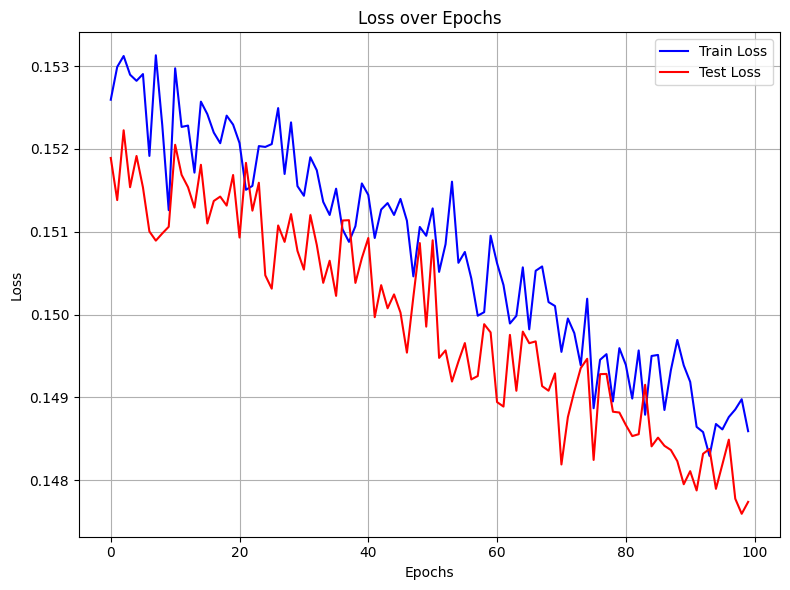

In [18]:
plot_metrics(train_loss_epochs, test_loss_epochs, 'Loss')

## **Task D (10 points): Denoising Last 5 Classes, Reporting Loss, and Visualization**

Use your model to denoise images from classes 5-9 of the SVHN dataset. Report the test loss and visualize clean, noisy, and denoised images side by side. Include these results in your report.


In [110]:
# Load test data for classes 5-9 with 1,500 samples per class

learning_rate = 0.05
batch_size = 64
drop_rate = 0.3
num_samples = 1500
num_epochs = 100


criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Load data
paired_trainloader_last_five = create_paired_dataloader(list(range(5,10)), num_samples, batch_size, drop_rate, 'train')
paired_testloader_last_five = create_paired_dataloader(list(range(5,10)), num_samples, batch_size, drop_rate, 'test')


print(f'Number of batches in paired_testloader_last_five: {len(paired_testloader_last_five)}')



# Evaluate model on the last 5 classes test set and report loss

test_loss_epoch = evaluate(paired_testloader_last_five, model, criterion, device)
print(f"Average MSE Loss on test denoising: {test_loss_epoch}")

Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\train_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Using downloaded and verified file: ./data\test_32x32.mat
Number of batches in paired_testloader_last_five: 24
Average MSE Loss on test denoising: 0.14319761532048383


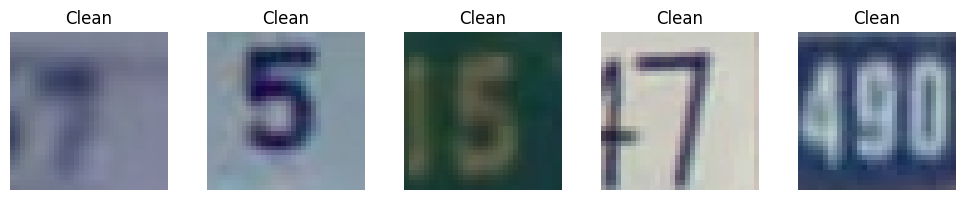

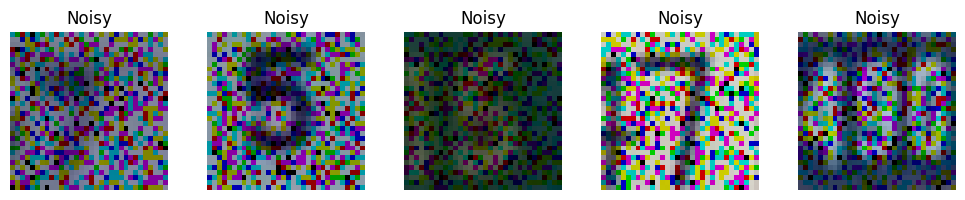

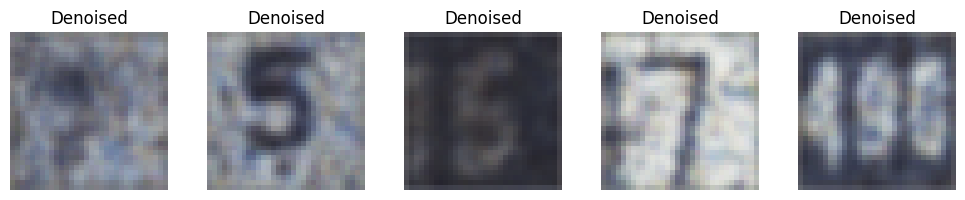

In [116]:
# Visualize clean, noisy, and denoised images on last 5 classes
clean_images = []
noisy_images = []
denoised_images = []
for batch_idx, (clean_images, noisy_images) in enumerate(paired_testloader_last_five):
    denoised_images = model(noisy_images)

# Display clean, noisy, and denoised images
show_images_grid2(clean_images[:5].detach(), title="Clean", cols=5)
show_images_grid2(noisy_images[:5].detach(), title="Noisy", cols=5)
show_images_grid2(denoised_images[:5].detach(), title="Denoised", cols=5)

# <font color="red"> Task 3: Kaggle Competition (25 + 20 Bonus Points) </font>

For this task, you will participate in a Kaggle competition. Follow the steps below to maximize your performance and gain additional points:

1. **Account Setup**: Create a Kaggle account if you don’t already have one, and log in. Make sure to include your Kaggle username in both your report and code submission for verification purposes.

2. **Competition Details**: Access the competition at the link provided below and thoroughly read the description and requirements. Implement your solution in a separate file (not in this notebook) and aim to achieve the highest score possible on the leaderboard.

   - **[Kaggle Competition Link](<https://www.kaggle.com/t/37714339d17855022339af848ed11e96>)**

3. **Submission on A2L**: Ensure your A2L submission includes:
   - **Final Code**: Upload your final code file used for the Kaggle competition.
   - **Report** (`kaggle.pdf`): Provide a detailed report explaining your model and approach, along with the code used in your last Kaggle submission.
     - Start the report with your final accuracy score.
     - Clearly mention your Kaggle username for verification.
   - **Submission File** (`submission.csv`): Upload the final `submission.csv` file used in the competition as a record of your performance.

4. **Bonus Points**: Additional points will be awarded to the top-performing students on the competition leaderboard.
